In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scienceplots
import os
import glob
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from pyemma.coordinates import tica
import warnings
import pandas as pd
from math import floor, log10
from tensorboard.backend.event_processing import event_accumulator
import warnings
warnings.filterwarnings("ignore")
plt.style.use(['science','no-latex'])
#colors
CYAN = "#00FFFF"

ORANGE = '#ffad33'
PINK = "#FF81C0"
MAGENTA = "#FF00FF"
YELLOW = "#FAC205"
SILVER = "#C5C9C7"
GRAY = "#929591"
DARK_GRAY = "#5b5b5b"
BLUE = "#069AF3"
DARK_BLUE = "#0000FF"
RBLUE = "#0088cc" #"#2d72ed"
RPURPLE = "#5c12de"
RYELLOW = "#dead12"
name_dict = {'pre': 'QM (1k) Training',
             'pre_copy': 'QM (1k) Training',
             'pre_copy2': 'QM (1k) Training',
             'pre_langevinlong': 'QM (1k) Training',
             'pre_temp250': 'QM (1k) Training',
             'post_temp250': 'QM (1k) + StABlE Training',
             'pre_temp350': 'QM (1k) Training',
             'post_temp350': 'QM (1k) + StABlE Training',
             'pre_temp750': 'QM (1k) Training',
             'post_temp750': 'QM (1k) + StABlE Training',
             'pre_temp700': 'QM (1k) Training',
             'post_temp700': 'QM (1k) + StABlE Training',
             'post_cycle1': 'QM (1k) + StABlE Training',
             'post_cycle1_copy': 'QM (1k) + StABlE Training',
             'post_cycle1_copy2': 'QM (1k) + StABlE Training',
             'post_cycle1_epoch10': 'QM (1k) + 10 Epochs Observable Training',
             'post_cycle1_epoch20': 'QM (1k) + 20 Epochs Observable Training',
             'post_cycle2': 'QM (1k) + 2 Cycles Observable Training',
             'post_cycle3': 'QM (1k) + 3 Cycles Observable Training',
             'post': 'QM (1k) + StABlE Training',
             'post_langevinlong': 'QM (1k) + StABlE Training',
             '10k': 'QM (10k) Training',
             '50k': 'QM (50k) Training',
             '10percent': 'QM (10%) Training',
             '25percent': 'QM (25%) Training'
            }
import matplotlib.pylab as pylab
params = {'figure.dpi': 900,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family': 'DejaVu Sans'}
from matplotlib import rc
pylab.rcParams.update(params)
lr_dict = {'1e-05': 0.00001,
           '3e-05': 0.00003,
           '0.0001': 0.0001,
           '0.0003': 0.0003,
           '0.001': 0.001,
}

def calc_cdf(stab, max_time=300):
    _cdf = np.array([(stab <= i).sum() / stab.shape[0] for i in range(max_time)])
    return _cdf

def round3(x):
    """ Round a number to 3 significant digits. """
    try:
        return round(x, 2 - int(floor(log10(abs(x)))) - 1) if x != 0 else 0
    except:
        return x
    

def plot_data_from_tfevents(exp_dir, molecule, fields, fig_name = None):
    # Initialize an accumulator to load the tfevents file
    search_pattern = os.path.join(exp_dir, '*tfevents*')
    tfevents_files = glob.glob(search_pattern)
    ids = np.array([int(filename.split(".")[-4]) for filename in tfevents_files])
    idxs = np.argsort(ids)
    tfevents_file_path = tfevents_files[idxs[-1]] #get most recent file
                   
    ea = event_accumulator.EventAccumulator(tfevents_file_path,
                                            size_guidance={
                                                event_accumulator.SCALARS: 0
                                            })
    ea.Reload()  # Load the file
    fig, ax1 = plt.subplots(figsize = (8, 4.8))
    plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False,length = 12, width = 3)
    plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3, labelsize=24)
    


    # Extract scalar data for first field
    field_data = ea.scalars.Items(fields[0])
    # Extract steps and loss values
    steps = [int(s.step) for s in field_data]
    values = [float(s.value) for s in field_data]
    ax1.plot(steps, values, DARK_GRAY, label = fields[0], linewidth=1.5) 
    ax1.set_xlabel('Training Epoch', fontsize=22)
    ax1.set_ylabel(fields[0], color=DARK_GRAY, fontsize=18)
    
    # Extract scalar data for second field
    field_data = ea.scalars.Items(fields[1])
    # Extract steps and loss values
    steps = [int(s.step) for s in field_data]
    values = [float(s.value) for s in field_data]
    
    # Create a second y-axis for the second plot
    ax2 = ax1.twinx()
    
    ax2.plot(steps, values, color = 'grey', linestyle = 'dashed', label = fields[1], linewidth=1.25)  # Plot the second dataset in blue
    ax2.set_ylabel(fields[1], color= 'grey', fontsize=22)
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax2.tick_params(length = 12, width = 3, labelsize = 24)

    # plt.title(molecule[0].upper() + molecule[1:] + " Training", fontsize=22)
    for ax in [ax1, ax2]:
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.yaxis.set_minor_locator(plt.NullLocator())
        # Customize the ticks
        # Disable top border ticks
        ax.tick_params(top=False)
    plt.savefig(f"Figures/{fig_name}.pdf")
    plt.show()
   
    
    

            
def plot_stability_distribution(molecule, exp_dir, names, max_time=None, cdf = False, fig_name = None):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure(figsize = (8, 4.8))
    bins = np.linspace(1, max_time, 50) if max_time is not None else 50
    colors = [RBLUE, ORANGE, MAGENTA, GRAY]
    for name, color in zip(names, colors):
        try:
            stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
            if max_time is not None:
                stab = stab[stab < max_time]
        except FileNotFoundError:
            pass
        if cdf:
            _cdf = calc_cdf(stab)
            
            plt.plot(_cdf, label = name_dict[name], alpha=1.0, color = color, linewidth=2.5)
            if 'post' in name:
                plt.xlim([0, stab.max()-1])
        else:
            a = 0.9 if GRAY in color else 0.8
            plt.hist(stab, bins = bins, label = name_dict[name], density=False, alpha=a, color = color)
    # plt.title(molecule[0].upper() + molecule[1:], fontsize=22)
    # plt.legend(loc = 'upper right', fontsize = 22)
    plt.xlabel("Simulation Time (ps)" if cdf else "Stable Simulation Time (ps)", fontsize=22)
    plt.ylabel("Fraction of Unstable Replicas" if cdf else "Number of Simulations", fontsize=18 if cdf else 22)
    plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 12, width = 3)
    plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3, labelsize = 24)
    plt.savefig(f"Figures/{fig_name}.pdf")
    
    
def plot_dt_analysis(molecule, exp_dir, names, fig_name = None):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure(figsize = (8, 6))
    # colors = [RBLUE, ORANGE, MAGENTA, GRAY]
    
    pre_stabs = []
    post_stabs = []
    pre_stds = []
    post_stds = []
    if 'water' in molecule:
        x = np.logspace(log10(0.1), log10(1), 5)
    else:
        x = np.logspace(log10(0.05), log10(0.5), 5)
    for name in names:
        try:
            stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
            mean_stab = np.mean(stab)
            std_stab = np.std(stab)
        except:
            try:
                # Initialize an accumulator to load the tfevents file
                search_pattern = os.path.join(inference_dir, name, '*tfevents*')
                tfevents_files = glob.glob(search_pattern)
                ids = np.array([int(filename.split(".")[-4]) for filename in tfevents_files])
                idxs = np.argsort(ids)
                tfevents_file_path = tfevents_files[idxs[-1]] #get most recent file

                ea = event_accumulator.EventAccumulator(tfevents_file_path,
                                                        size_guidance={
                                                            event_accumulator.SCALARS: 0
                                                        })
                ea.Reload()  # Load the file

                field_data = ea.scalars.Items("Fraction of Unstable Replicas")
                # Extract steps and values
                values = [float(s.value) for s in field_data]
                stab = np.array(values)
                mean_stab = np.argmin(np.abs(stab - 0.5))

                #get std dev
                pdf = stab[1:] - stab[:-1]
                times = torch.arange(1, len(stab))
                # Calculate the mean of the distribution
                mean = torch.sum(times * pdf)
                # Calculate the variance
                variance = torch.sum(((times - mean) ** 2) * pdf)
                # Standard deviation is the square root of the variance
                std_stab = torch.sqrt(variance)
            except:
                print(name)
                mean_stab = 0
                std_stab = 0
                
            
        if "pre" in name:
            pre_stabs.append(mean_stab)
            pre_stds.append(std_stab)
        else:
            post_stabs.append(mean_stab)
            post_stds.append(std_stab)
        
        
    plt.errorbar(x, pre_stabs, yerr=pre_stds, fmt='-o', capsize=5, label='QM (1k) Training', color = RBLUE, linewidth = 2.5)
    if len(post_stabs) !=0:
        plt.errorbar(x, post_stabs, yerr=post_stds, fmt='-o', capsize=5, label='QM (1k) + StABlE Training', color = ORANGE, linewidth = 2.5)
        
    # plt.title(molecule[0].upper() + molecule[1:], fontsize=22)
    # plt.legend(loc = 'upper right', fontsize = 22)
    plt.xlabel("Simulation Timestep (fs)", fontsize=24)
    plt.ylabel("Mean Stable Simulation Time (ps)", fontsize=20)
    # plt.legend(fontsize=12, loc = "upper right")
    plt.xscale('log')
    plt.tick_params(axis='both', which='minor', bottom=True, top=False, left=False, right=False, length = 6, width = 1.5)
    plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3)

    
    
    plt.savefig(f"Figures/{fig_name}.pdf")

    
def plot_observable_mae_distribution(molecule, exp_dir, names, observable = 'rdf', boxplot = False, fig_name = None):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure(figsize = (8, 4.8) if not boxplot else (1.5, 4.8))
    bins = 50
    if 'rdf' in observable:
        bins = np.linspace(0, 3, 20)
    all_maes = []
    colors = [RBLUE, ORANGE, PINK, YELLOW]
    for name, color in zip(names, colors):
        try:
            if "diffusivity" in observable:
                gt_diff = np.load(os.path.join(inference_dir, name, 'gt_diffusivity.npy'))
                pred_diffs = np.load(os.path.join(inference_dir, name, f'final_diffusivities.npy'))
                # maes = np.abs(10*(gt_diff[-1] - pred_diffs))
                maes = 10*pred_diffs
            else:
                maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
        except FileNotFoundError:
            pass
        if boxplot:
            all_maes.append(maes)
        else:
            plt.hist(maes, bins, label = name_dict[name], density=False, alpha=0.9, color = color)
            plt.xlabel(f"{observable.upper()} MAE", fontsize=22)
            plt.ylabel("Number of Simulations", fontsize=22)
    if boxplot:
#         plt.boxplot(all_maes)
#         plt.xticks([y + 1 for y in range(len(all_maes))],
#                   labels=[name_dict[name] for name in names], fontsize=6)
#         plt.ylabel("Diffusivity MAE", fontsize=10)
#         plt.ylim([0, 20])
        # Assuming all_maes is a list of lists where each inner list contains the MAEs for one group
        for i, (name, group) in enumerate(zip(names, all_maes)):
            y = [i + 0.05] * len(group)  # Create a list of the same x value for each point in the group
            plt.scatter(y, group, alpha=1.0, color = RBLUE if "pre" in name else ORANGE)  # Plot the points
            print(np.mean(group))
            plt.ylabel("Final Diffusivity ($10^{-9} m^2/s$)", fontsize=12)

        plt.xticks([y + 0.1 for y in range(len(all_maes))], labels=[name_dict[name] for name in names],fontsize=2)
        
        

        plt.axhline(2.37, color = "black")
        ax = plt.gca()

        ax.yaxis.set_label_coords(1.4, 1.1)
        
        # Increase the padding of the x-axis labels
        ax.xaxis.set_tick_params(pad=10)
        ax.set_yscale("linear")
        ax.set_ylim([0, 6])
        ax.spines['top'].set_visible(False)
        


        divider = make_axes_locatable(ax)
        axlog = divider.append_axes("top", size=2.0, pad=0, sharex=ax)
        axlog.set_yscale('log')
        axlog.set_ylim((6, 100))
        axlog.spines['bottom'].set_visible(False)
        axlog.xaxis.set_visible(False)
        axlog.spines['bottom'].set_visible(False)
        
        for i, (name, group) in enumerate(zip(names, all_maes)):
            y = [i + 0.05] * len(group)  # Create a list of the same x value for each point in the group
            axlog.scatter(y, group, alpha=1.0, color = RBLUE if "pre" in name else ORANGE)  # Plot the points
            print(np.mean(group))

        
        

        # plt.ylim([0, 5])
        # plt.semilogy([1, 2, 3, 4, 5, 20])
        ax.yaxis.tick_right()
        axlog.yaxis.tick_right()
        ax.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 4, width = 1, labelsize=6)
        ax.tick_params(axis='both', which='major', bottom=False, top=False, left=True, right=True, length = 6, width = 1.5, labelsize=10)


        axlog.tick_params(axis='both', which='major', bottom=False, top=False, left=False, right=False, length = 4, width = 1, labelsize=10)
        axlog.tick_params(axis='both', which='minor', bottom=False, top=False, left=True, right=True, length = 6, width = 1.5, labelsize=6)
    else:
        plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 12, width = 3)
        plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3, labelsize = 24)

    plt.savefig(f"Figures/{fig_name}.pdf")
    plt.show()
    
    # plt.title(molecule[0].upper() + molecule[1:], fontsize=22)
    # plt.legend(loc = 'upper right')
    #plt.xlim([0,0.2])
    
    
    

def plot_observable_mae_difference_distribution(molecule, exp_dir, names, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    for name in names:
        if "pre" not in name and 'k' not in name:
            try:
                maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            except FileNotFoundError:
                pass
            plt.hist(100*(maes - pre_maes)/pre_maes, bins = 50, label = name_dict[name], density=True, alpha=0.7) 
    # plt.title(molecule[0].upper() + molecule[1:], fontsize=22)
    # plt.legend(loc = 'upper right')
    plt.xlabel(f"Change in {observable.upper()} MAE after Observable Training (%)", fontsize=8)
    plt.ylabel("Frequency", fontsize=22)
    
def plot_observable(molecule, exp_dir, names, observable = 'rdf', criterion = 'stab', mode = 'mean', diff = False, _replica = None, fig_name = None):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure(figsize = (10, 4.8) if "diffusivity" not in observable else (5, 4.8))
    pre_name = names[0] if "pre" in names[0] else "pre"
    if 'diffusivity' in observable:
        # pre_obs = np.load(os.path.join(inference_dir, pre_name, 'all_msds.npy'), allow_pickle=True)
        pre_obs = np.load(os.path.join(inference_dir, pre_name, 'all_diffusivities.npy'), allow_pickle=True)
        pre_mean_diffusivity = torch.cat([ob[-1].unsqueeze(0) for ob in pre_obs]).mean()
        # gt_obs = np.load(os.path.join(inference_dir, names[0], f'gt_msd.npy'), allow_pickle=True)
        # gt_obs = np.load('/global/homes/s/sanjeevr/implicit-md/water_msd.npy')[::20][:100]
        gt_obs = np.load(os.path.join(inference_dir, names[0], f'gt_{observable}.npy'))
        print('gt', (gt_obs[-1] - gt_obs[0]) / len(gt_obs))
        gt_obs = np.load(os.path.join(inference_dir, names[0], f'gt_{observable}.npy'))
        pre_maes = torch.cat([torch.abs(10*(gt_obs[-1] - ob[-1])).unsqueeze(0) for ob in pre_obs])
        pre_stab = np.load(os.path.join(inference_dir, pre_name, 'replicas_stable_time.npy'))
#         pre_obs = [pre_ob / torch.arange(1, ps) / 6 for pre_ob, ps in zip(pre_obs, pre_stab)]# adjust for diffusivity issue
#         gt_obs /= torch.arange(1, 101) / 6 #adjust for diffusivity issue
    
    else:
        pre_maes = np.load(os.path.join(inference_dir, pre_name, f'final_{observable}_maes.npy'))
        pre_stab = np.load(os.path.join(inference_dir, pre_name, 'replicas_stable_time.npy'))
        pre_obs = np.load(os.path.join(inference_dir, pre_name, f'final_{observable}s.npy'))
        # gt_obs = np.load(os.path.join(inference_dir, names[0], f'water_msd.npy'))
        gt_obs = np.load(os.path.join(inference_dir, names[0], f'gt_{observable}.npy'))
        pre_replica = np.argmin(np.abs(pre_stab - np.median(pre_stab))) if criterion == 'stab' else \
                        np.argmin(np.abs(pre_maes - np.median(pre_maes)))
                    
    if 'rdf' in observable:
        if "water" not in exp_dir:
            gt_obs /=2 #why did we do this again?
        if 'md22' in exp_dir:
            x_axis = np.linspace(0, 15, 750) 
        elif 'md17' in exp_dir:
            x_axis = np.linspace(0, 10, 500)
        else:
            x_axis = np.linspace(0, 6, 500)
    elif observable == 'adf':
        x_axis = np.linspace(0, np.pi, 180)
    elif observable == 'vacf':
        x_axis = np.linspace(0, 50, 100)
    
#     if 'diffusivity' not in observable:
#         plt.plot(x_axis, pre_obs[pre_replica], label=name_dict["pre"], color = DARK_BLUE)

    for name in names:
        if "pre" not in name:
            try:
                stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
                if 'diffusivity' in observable:
                    obs = np.load(os.path.join(inference_dir, name, 'all_diffusivities.npy'), allow_pickle=True)
                    mean_diffusivity = torch.cat([ob[-1].unsqueeze(0) for ob in obs]).mean()
                    print("GT Diffusivity: ", gt_obs[-1], "Pre Diffusivity: ", pre_mean_diffusivity, "Post Diffusivity: ", mean_diffusivity)
                    # obs = np.load(os.path.join(inference_dir, name, 'all_msds.npy'), allow_pickle=True)
                    stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
                    maes = torch.cat([torch.abs(10*(gt_obs[-1] - ob[-1])).unsqueeze(0) for ob in obs])
#                     obs = [ob / torch.arange(1, s) / 6 for ob, s in zip(obs, stab)] #adjust for diffusivity issue
                else:
                    maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
                    obs = np.load(os.path.join(inference_dir, name, f'final_{observable}s.npy'), allow_pickle = True)
            except FileNotFoundError:
                pass
            percent_change_mae = 100*(maes - pre_maes)/pre_maes
            if mode == "max":
                mean_percent_change_mae = percent_change_mae.max()
            else:
                mean_percent_change_mae = percent_change_mae.mean()
            mean_mae_replica = np.argmin(np.abs(maes - np.median(maes)))
            if mode == 'max':
                mean_stab_imp_replica = np.argmax(stab-pre_stab)
            else:
                # mean_stab_imp_replica = np.argmin(np.abs(stab - np.median(stab)))
                mean_stab_imp_replica = np.argmin(np.abs((stab-pre_stab) - np.median((stab - pre_stab))))
            if _replica is not None:
                replica = _replica
            else:
                replica = mean_stab_imp_replica if criterion == "stab" else mean_mae_replica
            if diff:
                plt.plot(x_axis, (pre_obs[replica] - gt_obs) / (gt_obs + 1e-1), label=name_dict["pre"], color = RBLUE, linewidth=2)
            else:
                if 'diffusivity' in observable:
                    # pass
                    for r in replica:
                        plt.plot(10*pre_obs[r], label=name_dict["pre"] if r==0 else None, color = RBLUE, linewidth=2.0)
                        print(pre_name, (pre_obs[r][-1] - pre_obs[r][0]) / len(pre_obs[r]) - 1.37)
                else:
                    print("Plotted replica, pre and post MAEs: ", pre_maes[replica], maes[replica])
                    print("Average over all replicas, pre and post MAEs:", np.mean(pre_maes), np.mean(maes))
                    plt.plot(x_axis, pre_obs[replica], label=name_dict["pre"], color = RBLUE, linewidth = 2.0)
            if not diff:
                if 'diffusivity' in observable:
                    plt.plot(10*gt_obs, label="Reference Simulation", color = 'black')
                else:
                    plt.plot(x_axis, gt_obs, label="AIMD Reference" if "water" not in exp_dir else "Reference Simulation", color = 'black', linewidth=2.0)
            if diff:
                plt.plot(x_axis, (obs[replica] - gt_obs) / (gt_obs + 1e-1), label=name_dict[name], color = ORANGE, linewidth=2)
                plt.plot(x_axis, np.zeros_like(x_axis), label = "Reference", color = 'black', linewidth=2)
            else:
                if 'diffusivity' in observable:
                    # pass
                    for r in replica:
                        plt.plot(10*obs[r], label=name_dict[name] if r==0 else None, color = 'ORANGE', linestyle = 'solid', linewidth=2.0)
                        print(name, (obs[r][-1] - obs[r][0]) / len(obs[r]) - 1.37)
                else:
                    plt.plot(x_axis, obs[replica], label=name_dict[name], color = ORANGE, linestyle = 'solid' if 'post' in name else 'solid', linewidth=2.0)
    
    
    if 'rdf' in observable:
        xlabel = "$r$ (Angstroms)"
        ylabel = "$h(r)$" if "md17" in exp_dir or "md22" in exp_dir else f'{observable.split("_")[0]} $g(r)$'
        title  = "Distribution of Interatomic Distances" "h(r)" if "md17" in exp_dir or "md22" in exp_dir else f'{observable.split("_")[0]} Radial Distribution Function'
        if 'HO' in observable:
            plt.ylim([0,6])
    elif observable == 'adf':
        xlabel = "Angle (radians)"
        ylabel = "ADF"
        title  = "Angular Distribution Function"
    elif observable == 'vacf':
        xlabel = "Time lag (fs)"
        ylabel = "Normalized VACF"
        title  = "Velocity Autocorrelation Function"
    elif observable == 'diffusivity':
        xlabel = "Simulation Time (ps)"
        ylabel = "Diffusivity ($10^{-9} m^2/s$)"
        title  = "Diffusivity Coefficient"
        plt.xlim([0,81])
        plt.ylim([0, 5])
#         plt.xlim([0, 75])
        # plt.ylim([0, 150])
    
    if diff:
        title +=" Difference"
        ylabel = "$h(r) - h_{ref}(r)$"
    
    # plt.title(molecule[0].upper() + molecule[1:] + ": " + title, fontsize=12)
    plt.xlabel(xlabel, fontsize=36 if diff else 22)
    plt.ylabel(ylabel, fontsize= 36 if diff else 28)
    # plt.legend(loc = 'upper right', fontsize=18)
    plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 12, width = 3)
    plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3, labelsize = 24 if not diff else 36)
    plt.savefig(f"Figures/{fig_name}.pdf")

    
    
    
def collect_metrics(molecule, exp_dir, names, water = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    mean_rdf_maes = []
    mean_hh_rdf_maes = []
    mean_ho_rdf_maes = []
    mean_oo_rdf_maes = []
    mean_adf_maes = []
    mean_vacf_maes = []
    std_rdf_maes = []
    std_hh_rdf_maes = []
    std_ho_rdf_maes = []
    std_oo_rdf_maes = []
    std_adf_maes = []
    std_vacf_maes = []
    mean_stability = []
    std_stability = []
    mean_force_mae = []
    mean_diffusivity_maes = []
    std_diffusivity_maes = []
    used_names = []
    if len(names) == 0:
        names = os.listdir(inference_dir)
    for name in names:
        try:
            metrics = json.load(open(os.path.join(inference_dir, name, 'final_metrics.json')))
            if water:
                mean_hh_rdf_maes.append(round3(metrics['Mean HH RDF MAE']))
                mean_ho_rdf_maes.append(round3(metrics['Mean HO RDF MAE']))
                mean_oo_rdf_maes.append(round3(metrics['Mean OO RDF MAE']))
                mean_adf_maes.append(round3(metrics['Mean ADF MAE']))
                std_hh_rdf_maes.append(round3(metrics['Std Dev HH RDF MAE']))
                std_ho_rdf_maes.append(round3(metrics['Std Dev HO RDF MAE']))
                std_oo_rdf_maes.append(round3(metrics['Std Dev OO RDF MAE']))
                std_adf_maes.append(round3(metrics['Std Dev ADF MAE']))
                mean_stability.append(round3(metrics['Mean Stability (ps)']))
                std_stability.append(round3(metrics['Std Dev Stability (ps)']))
                mean_force_mae.append(round3(metrics['Force MAE']))
                mean_diffusivity_maes.append(round3(metrics["Mean Diffusivity MAE (10^-9 m^2/s)"]))
                std_diffusivity_maes.append(round3(metrics["Std Dev Diffusivity MAE (10^-9 m^2/s)"]))
            else:
                mean_rdf_maes.append(round3(metrics['Mean RDF MAE']))
                mean_adf_maes.append(round3(metrics['Mean ADF MAE']))
                mean_vacf_maes.append(round3(metrics['Mean VACF MAE']))
                std_rdf_maes.append(round3(metrics['Std Dev RDF MAE']))
                std_adf_maes.append(round3(metrics['Std Dev ADF MAE']))
                std_vacf_maes.append(round3(metrics['Std Dev VACF MAE']))
                mean_stability.append(round3(metrics['Mean Stability (ps)']))
                std_stability.append(round3(metrics['Std Dev Stability (ps)']))
                mean_force_mae.append(round3(metrics['Force MAE']))
            used_names.append(name)
        except FileNotFoundError:
            pass
        
    # Creating a DataFrame
    if water:
        data = {
            "Mean HH RDF MAE": mean_hh_rdf_maes,
            "Mean HO RDF MAE": mean_ho_rdf_maes,
            "Mean OO RDF MAE": mean_oo_rdf_maes,
            "Mean ADF MAE": mean_adf_maes,
            "Std Dev HH RDF MAE": std_hh_rdf_maes,
            "Std Dev HO RDF MAE": std_ho_rdf_maes,
            "Std Dev OO RDF MAE": std_oo_rdf_maes,
            "Std Dev ADF MAE": std_adf_maes,
            "Mean Stability (ps)": mean_stability,
            "Std Dev Stability (ps)": std_stability,
            "Mean Diffusivity MAE (10^-9 m^2/s)": mean_diffusivity_maes,
            "Std Dev Diffusivity MAE (10^-9 m^2/s)": std_diffusivity_maes,
            "Force MAE": mean_force_mae
        }
    else:
        data = {
            "Mean RDF MAE": mean_rdf_maes,
            "Mean ADF MAE": mean_adf_maes,
            "Mean VACF MAE": mean_vacf_maes,
            "Std Dev RDF MAE": std_rdf_maes,
            "Std Dev ADF MAE": std_adf_maes,
            "Std Dev VACF MAE": std_vacf_maes,
            "Mean Stability (ps)": mean_stability,
            "Std Dev Stability (ps)": std_stability,
            "Force MAE": mean_force_mae
        }
    pd.set_option('display.float_format', '{:.3g}'.format)
    df = pd.DataFrame(data, index=used_names)
    combined_df = pd.DataFrame(index=used_names)
    # Adding mean and standard deviation values in parentheses for each metric
    combined_df["Stability (ps)"] = df["Mean Stability (ps)"].astype(str) + " (" + df["Std Dev Stability (ps)"].astype(str) + ")"
    combined_df["ADF MAE"] = df["Mean ADF MAE"].astype(str) + " (" + df["Std Dev ADF MAE"].astype(str) + ")"
    combined_df["Force MAE"] = df["Force MAE"].astype(str)  # No standard deviation for Force MAE
    if water:
        combined_df["HH RDF MAE"] = df["Mean HH RDF MAE"].astype(str) + " (" + df["Std Dev HH RDF MAE"].astype(str) + ")"
        combined_df["HO RDF MAE"] = df["Mean HO RDF MAE"].astype(str) + " (" + df["Std Dev HO RDF MAE"].astype(str) + ")"
        combined_df["OO RDF MAE"] = df["Mean OO RDF MAE"].astype(str) + " (" + df["Std Dev OO RDF MAE"].astype(str) + ")"
        combined_df["Diffusivity MAE"] = df["Mean Diffusivity MAE (10^-9 m^2/s)"].astype(str) + " (" + df["Std Dev Diffusivity MAE (10^-9 m^2/s)"].astype(str) + ")"
    else:
        combined_df["RDF MAE"] = df["Mean RDF MAE"].astype(str) + " (" + df["Std Dev RDF MAE"].astype(str) + ")"
        combined_df["VACF MAE"] = df["Mean VACF MAE"].astype(str) + " (" + df["Std Dev VACF MAE"].astype(str) + ")"
    
    print(molecule)
    return combined_df.T

def plot_energy_force_analysis(molecule, exp_dir, name, field, plot=True, fig_name = None):
    data = np.zeros((5,5))
    loss_coefficients = [1, 3, 10, 30, 100]
    lrs = ['1e-05', '3e-05', '0.0001', '0.0003', '0.001']
    for i, lr in enumerate(lrs):
        for j, ef_weight in enumerate(loss_coefficients):
            lr_num = lr_dict[lr]
            train_dir = f"{exp_dir}/IMPLICIT_schnet_{molecule}_HPO_lr={lr}_efweight={ef_weight}/"
            inference_dir = f"{exp_dir}/IMPLICIT_schnet_{molecule}_HPO_lr={lr}_efweight={ef_weight}/inference"
            
            # Initialize an accumulator to load the tfevents file
            search_pattern = os.path.join(inference_dir, name, '*tfevents*')
            tfevents_files = glob.glob(search_pattern)
            ids = np.array([int(filename.split(".")[-4]) for filename in tfevents_files])
            idxs = np.argsort(ids)
            tfevents_file_path = tfevents_files[idxs[-1]] #get most recent file

            ea = event_accumulator.EventAccumulator(tfevents_file_path,
                                                    size_guidance={
                                                        event_accumulator.SCALARS: 0
                                                    })
            ea.Reload()  # Load the file
            
            field_data = ea.scalars.Items(field)
            # Extract steps and values
            values = [float(s.value) for s in field_data]
            
            
            search_pattern = os.path.join(train_dir, '*tfevents*')
            tfevents_files = glob.glob(search_pattern)
            ids = np.array([int(filename.split(".")[-4]) for filename in tfevents_files])
            idxs = np.argsort(ids)
            tfevents_file_path = tfevents_files[idxs[-1]] #get most recent file

            ea = event_accumulator.EventAccumulator(tfevents_file_path,
                                                    size_guidance={
                                                        event_accumulator.SCALARS: 0
                                                    })
            ea.Reload()  # Load the file
            # Extract scalar data for first field
            field_data = ea.scalars.Items(field)
            # Extract steps and values
            train_values = [float(s.value) for s in field_data]
            
            if "MAE" in field or "RMSE" in field:
                data[i,j] = values[-1] / train_values[0]
            elif "Unstable" in field:
                values = np.array(values)
                train_values = np.array(train_values)
                data[i, j] = np.argmin(np.abs(values - 0.5)) / np.argmin(np.abs(train_values[0:36] - 0.5))
            
    # Create a meshgrid for plotting
    learning_rates = [lr_dict[lr] for lr in lrs]
    lr, lc = np.meshgrid(learning_rates, loss_coefficients)

    # Flatten the arrays for scatter plotting
    lr_flat = lr.flatten()
    lc_flat = lc.flatten()
    data_flat = np.log10(data).T.flatten()

    if plot:
        # Create the scatter plot
        plt.figure(figsize=(8, 4.8))
        scatter = plt.scatter(lr_flat, lc_flat, c=data_flat, cmap='plasma', s=1000)
        plt.colorbar(scatter).set_label(f"Log-Fold Increase in {field}" if "Unstable" not in field else "Log-Fold Increase in Median Stability", size=13)

        # Labeling the plot
        plt.xscale('log')  # since learning rates vary in orders of magnitude
        plt.yscale('log')  # if loss coefficients also vary widely
        plt.xlabel('Learning Rate', fontsize = 22)
        plt.ylabel('QM Loss Coefficient', fontsize = 22)
        plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 12, width = 3)
        plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 12, width = 3, labelsize=24)
        # plt.title('Scatter Plot of Learning Rate vs Loss Coefficient, Colored by Stability')
        plt.savefig(f"Figures/{fig_name}.pdf")
        plt.show()
        
    return data_flat
        


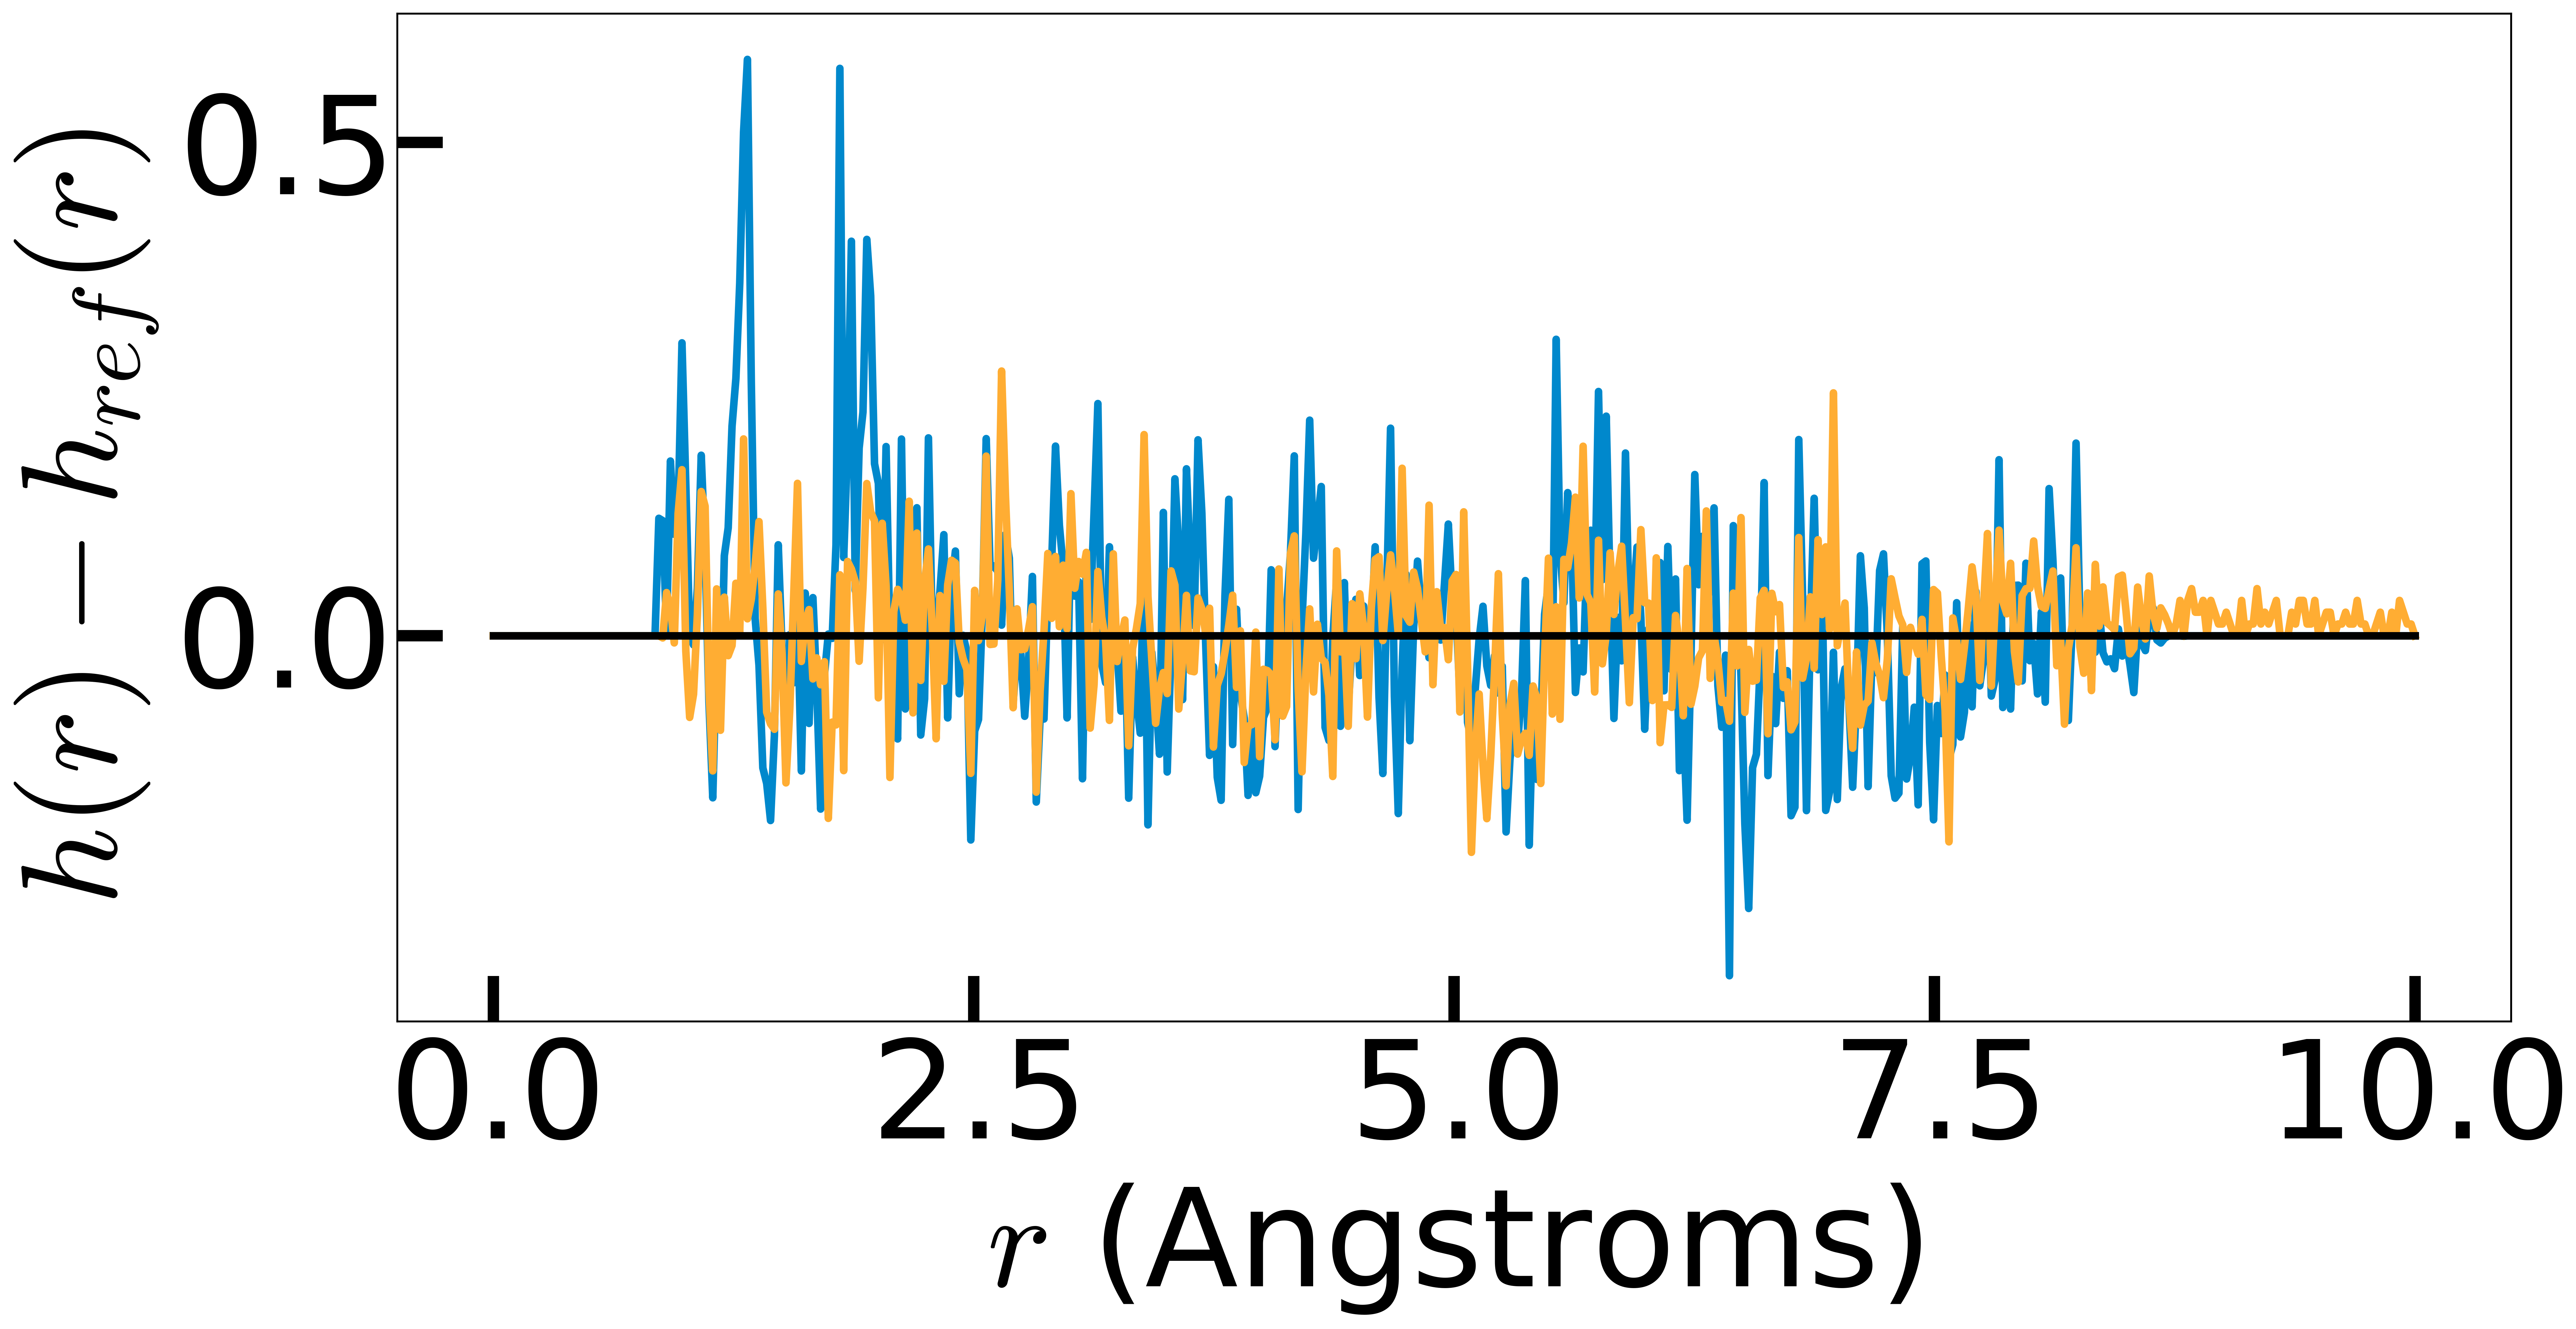

In [8]:
'''INPUTS'''
logdir = f'results_md17_correctedlogging'
molecule = "aspirin"    
model = "schnet" 
lr="0.001"
ef_weight="10" 

short_exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/results_md17_hpo/'
exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/{logdir}/IMPLICIT_{model}_{molecule}_TEST_correctedlogging_lr={lr}_efweight={ef_weight}'
names = ['pre_langevinlong', 'post_langevinlong', '10k', '50k']
# names = ['pre_dt05', 'pre_dt09','pre_dt16','pre_dt28','pre_dt5'] #,'post_cycle1_dt05', 'post_cycle1_dt09','post_cycle1_dt16','post_cycle1_dt28','post_cycle1_dt5'] #, '10k', '50k']#, 'post_cycle1_epoch20', 'post_cycle1']# 'post_cycle2', 'post_cycle3', 'post'] 
#display(collect_metrics(molecule, exp_dir, names))
# fields = ["Fraction of Unstable Replicas", "Learning Rate"]
# plot_dt_analysis(molecule, exp_dir, names, fig_name = "fig10a")
# plot_data_from_tfevents(exp_dir, molecule, fields, fig_name = "fig3a")
plot_stability_distribution(molecule, exp_dir, names, cdf = False, max_time=1000, fig_name = "fig3b")
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# names = ['pre', 'post']
# plot_stability_distribution(molecule, exp_dir, names, cdf = True, max_time=None, fig_name = "fig5a")
# plot_observable(molecule, exp_dir, names, 'rdf', diff=True, mode = 'mean', criterion = 'stab', fig_name = 'fig4d_mean_diff')


# plot_observable_mae_distribution(molecule, exp_dir, names, 'vacf', fig_name = 'fig3d')
# plot_observable_mae_difference_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable(molecule, exp_dir, names, 'rdf', diff=False, mode = 'mean', criterion = 'stab', fig_name = 'fig3c')
# stab_flat = plot_energy_force_analysis(molecule, short_exp_dir, 'post', 'Fraction of Unstable Replicas', plot = True, fig_name = "fig8a")
# force_mae_flat = plot_energy_force_analysis(molecule, short_exp_dir, 'post', 'Force MAE', plot = True, fig_name = "fig8b")
# plt.figure(figsize=(8, 4.8))
# plt.scatter(stab_flat, -1*force_mae_flat, s=49)
# plt.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False, length = 8, width = 2)
# plt.tick_params(axis='both', which='major', bottom=True, top=False, left=True, right=False, length = 8, width = 2, labelsize = 24)
# plt.xlabel("Log-Fold Stability Improvement", fontsize=22)
# plt.ylabel("Log-Fold Force MAE Improvement", fontsize =16)
# plt.savefig("Figures/fig8c.pdf")

4.9942913
1.5813916
4.9942913
1.5813916


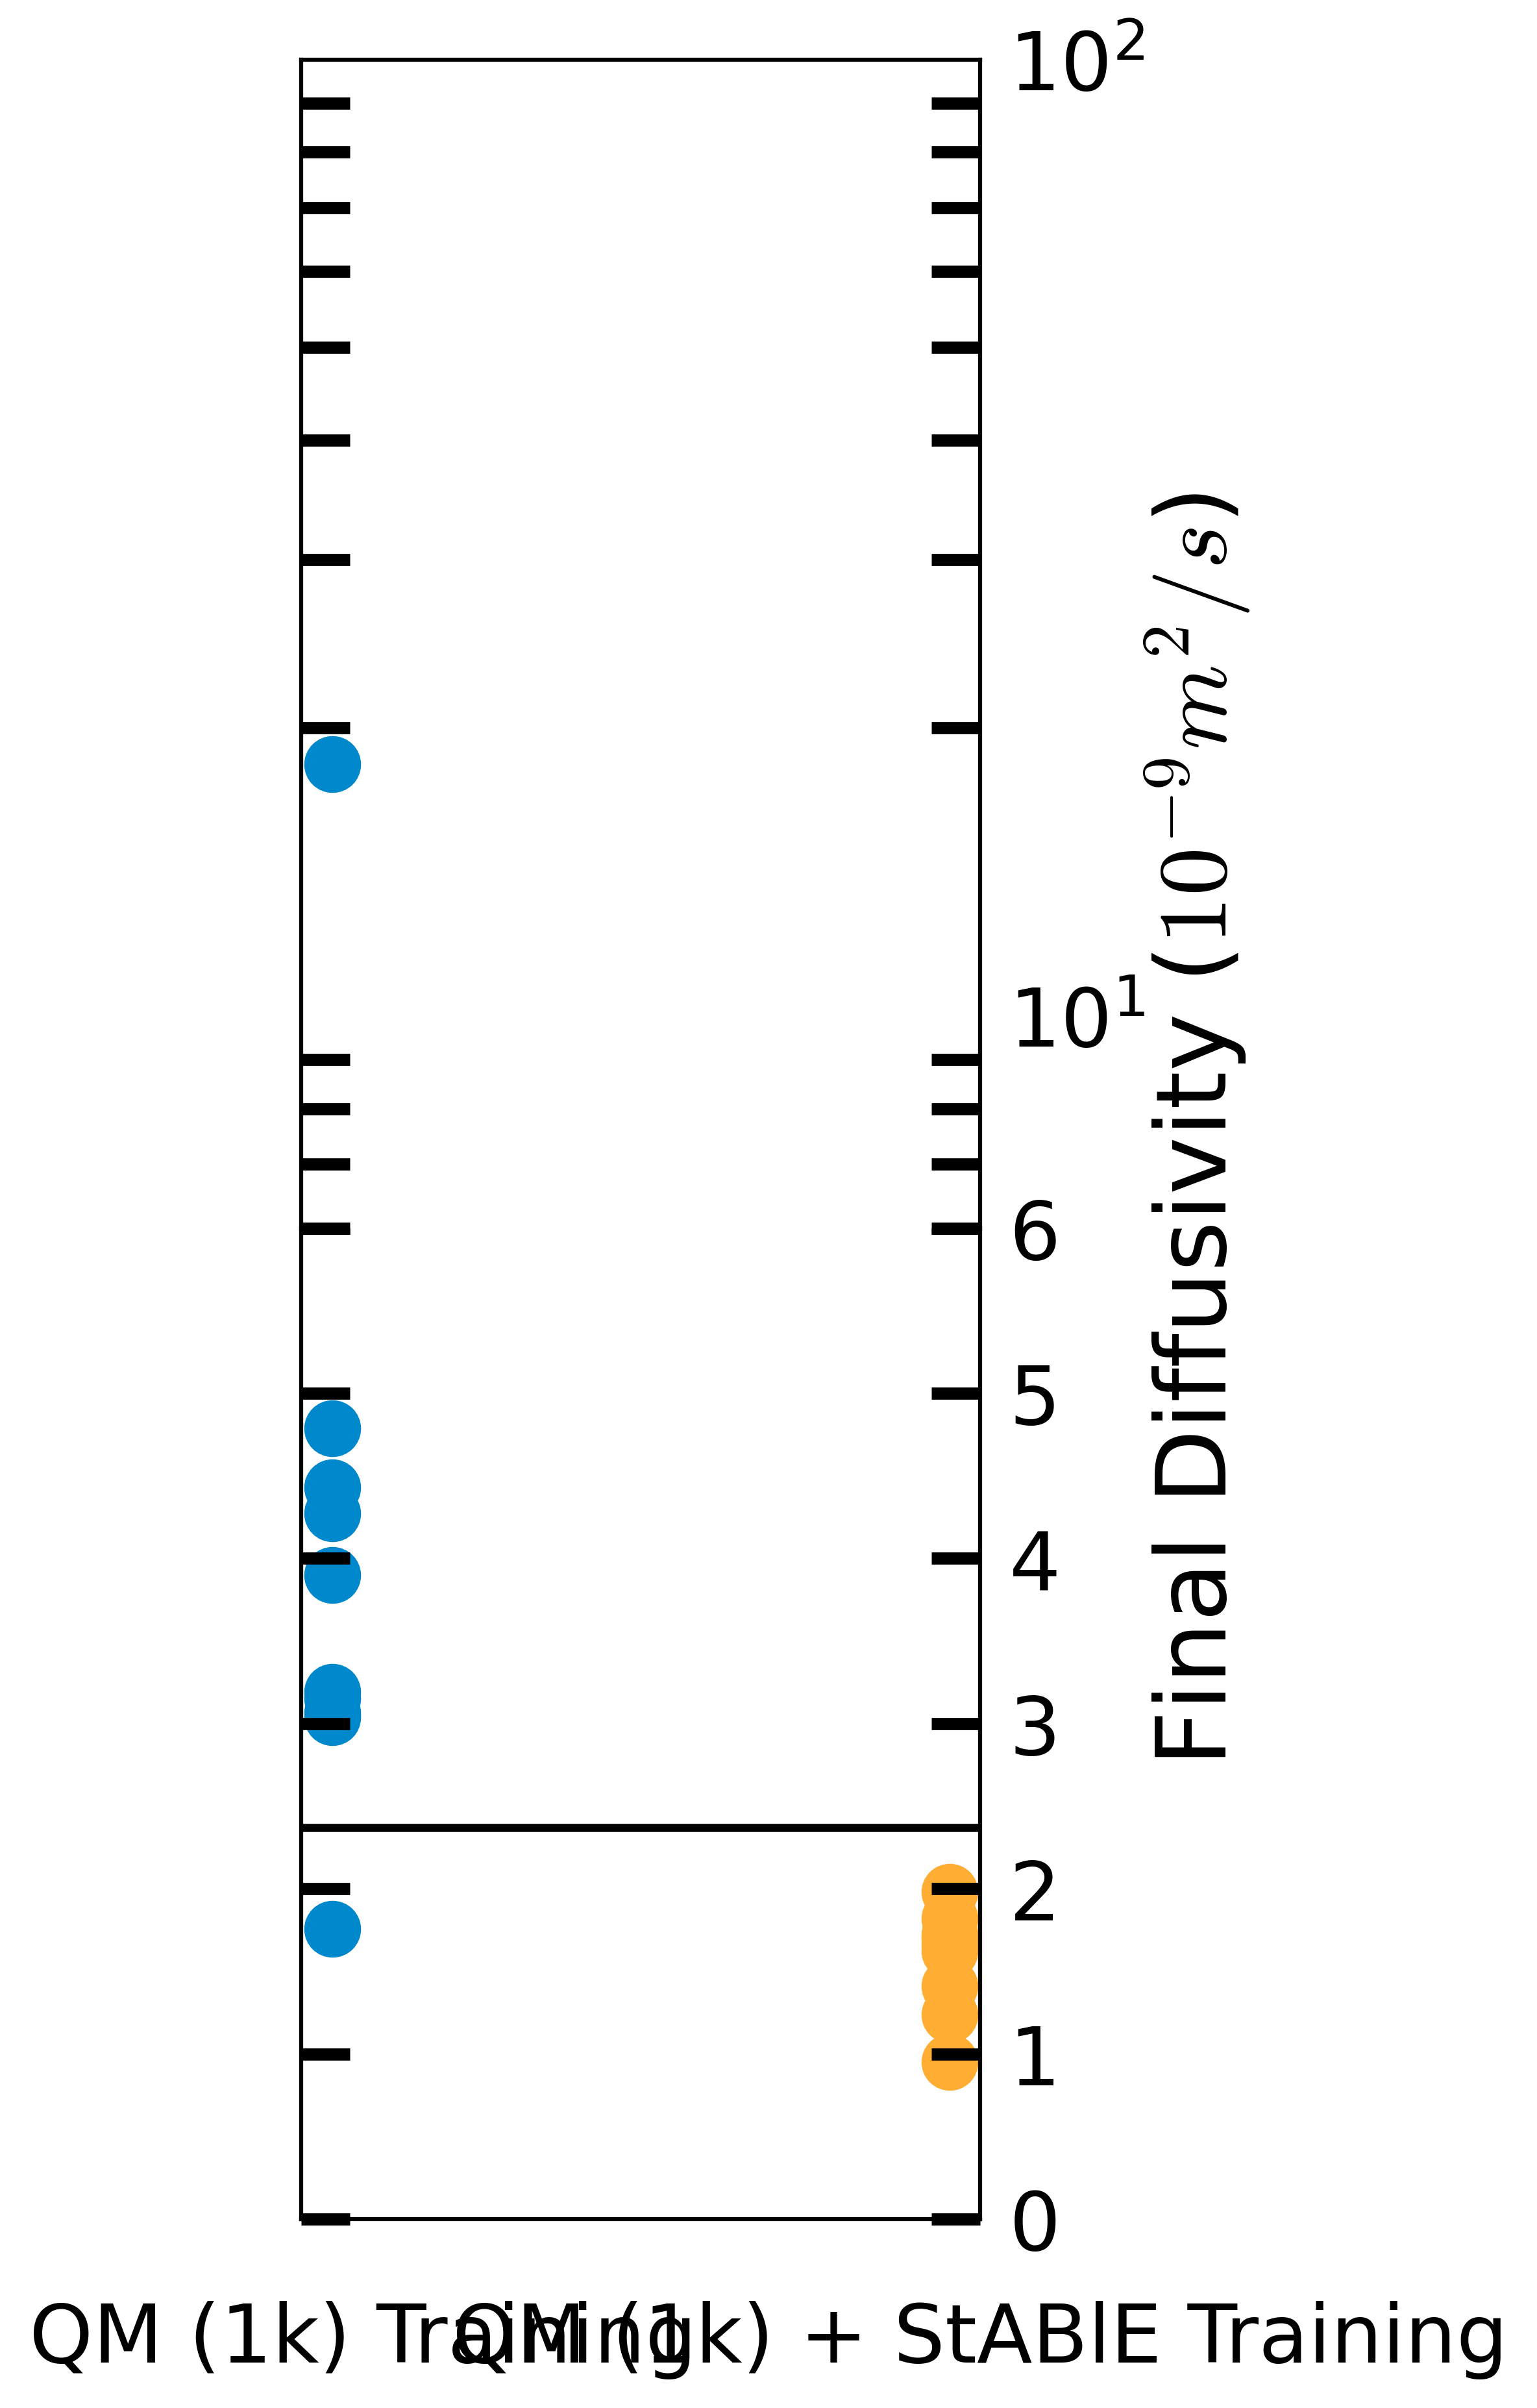

gt -0.0009505142271518707
GT Diffusivity:  0.2304249 Pre Diffusivity:  tensor(0.4994) Post Diffusivity:  tensor(0.1581)
pre_copy tensor(-1.3711)
pre_copy tensor(-1.3731)
pre_copy tensor(-1.3742)
pre_copy tensor(-1.3683)
pre_copy tensor(-1.3246)
pre_copy tensor(-1.3734)
pre_copy tensor(-1.3740)
pre_copy tensor(-1.3760)
pre_copy tensor(-1.3712)
pre_copy tensor(-1.3707)
post_cycle1_copy tensor(-1.3725)
post_cycle1_copy tensor(-1.3723)
post_cycle1_copy tensor(-1.3723)
post_cycle1_copy tensor(-1.3717)
post_cycle1_copy tensor(-1.3727)
post_cycle1_copy tensor(-1.3711)
post_cycle1_copy tensor(-1.3718)
post_cycle1_copy tensor(-1.3726)
post_cycle1_copy tensor(-1.3722)
post_cycle1_copy tensor(-1.3711)


In [ ]:
'''INPUTS'''
logdir = f'results_water_localneighborhoods'
molecule = 'water' 
model = "gemnet_t" 
lr="0.003" 
ef_weight="0" 
exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/{logdir}/IMPLICIT_{model}_{molecule}_TEST_bond_length_dev_singlemolecule_COPY_lr={lr}_efweight={ef_weight}'

names = ['pre', 'post_cycle1']
# names = ['pre_dtp1', 'pre_dtp18','pre_dtp3','pre_dtp56','pre_dt1'] #,'post_cycle1_dtp1', 'post_cycle1_dtp18','post_cycle1_dtp3','post_cycle1_dtp56','post_cycle1_dt1'] #, '10k', '50k']#, 'post_cycle1_epoch20', 'post_cycle1']# 'post_cycle2', 'post_cycle3', 'post'] 
# plot_dt_analysis(molecule, exp_dir, names, fig_name = "fig10c")
# plot_stability_distribution(molecule, exp_dir, names, cdf = True, fig_name = 'fig6b')
# plot_observable(molecule, exp_dir, names, 'HO_rdf', diff=False, mode = 'mean', criterion = 'stab', _replica=None, fig_name = 'fig6d')
# plot_observable(molecule, exp_dir, names, 'OO_rdf', diff=False, mode = 'mean', criterion = 'stab', _replica=None, fig_name = 'fig6e')
# plot_observable(molecule, exp_dir, names, 'HH_rdf', diff=False, mode = 'mean', criterion = 'stab', _replica=None, fig_name = 'fig6f')
# # fields = ["Fraction of Unstable Replicas", "Learning Rate"]
# # plot_data_from_tfevents(exp_dir, molecule, fields)
names = ['pre_copy', 'post_cycle1_copy']

plot_observable_mae_distribution(molecule, exp_dir, names, 'diffusivity', boxplot = True, fig_name='fig6c_2_actual')
plot_observable(molecule, exp_dir, names, 'diffusivity', diff=False, mode = 'mean', criterion = 'stab', _replica=range(10), fig_name = 'fig6c')
